In [1]:
import subprocess
from pyiron_base import Project
from pyiron_base.project.delayed import draw

In [2]:
# input parameter 
domain_size = 2.0

In [3]:
# create pyiron project 
pr = Project("workflow")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

In [4]:
env_dict = {
    "preprocessing": "source/envs/preprocessing.yaml",
    "processing": "source/envs/processing.yaml",
    "postprocessing": "source/envs/postprocessing.yaml"
}

In [5]:
def create_env(env_key):
    subprocess.check_output(
        ["mamba", "env", "create", "-n", env_key, "-f", env_dict[env_key], "-y"],
        universal_newlines=True,
    ).split("\n")

In [6]:
# Preprocessing
## generate mesh
gmsh = pr.wrap_executable(
    job_name="gmsh",
    executable_str=f"gmsh -2 -setnumber domain_size {domain_size} unit_square.geo -o square.msh",
    conda_environment_path=pr.conda_environment.preprocessing,
    input_file_lst=["source/unit_square.geo"],
    delayed=True,
    output_file_lst=["square.msh"],
)

In [7]:
## convert mesh to xdmf
meshio = pr.wrap_executable(
    job_name="meshio",
    executable_str="meshio convert square.msh square.xdmf",
    conda_environment_path=pr.conda_environment.preprocessing,
    input_file_lst=[gmsh.files.square_msh],
    delayed=True,
    output_file_lst=["square.xdmf", "square.h5"],
)

In [8]:
# Processing
## poisson
poisson = pr.wrap_executable(
    job_name="poisson",
    executable_str="python poisson.py --mesh square.xdmf --degree 2 --outputfile poisson.pvd --num-dofs numdofs.txt",
    conda_environment_path=pr.conda_environment.processing,
    input_file_lst=["source/poisson.py", meshio.files.square_xdmf, meshio.files.square_h5],
    delayed=True,
    output_file_lst=["poisson.pvd", "poisson000000.vtu", "numdofs.txt"],
)

In [9]:
# Postprocessing
## plot over line
pvbatch = pr.wrap_executable(
    job_name="pvbatch",
    executable_str="pvbatch postprocessing.py poisson.pvd plotoverline.csv",
    conda_environment_path=pr.conda_environment.postprocessing,
    input_file_lst=["source/postprocessing.py", poisson.files.poisson_pvd, poisson.files.poisson000000_vtu],
    delayed=True,
    output_file_lst=["plotoverline.csv"],
)

In [10]:
## substitute macros
macros = pr.wrap_executable(
    job_name="macros",
    executable_str=f"python prepare_paper_macros.py --macro-template-file macros.tex.template --plot-data-path plotoverline.csv --domain-size {domain_size} --num-dofs $(cat numdofs.txt) --output-macro-file macros.tex",
    input_file_lst=["source/macros.tex.template", "source/prepare_paper_macros.py", poisson.files.numdofs_txt, pvbatch.files.plotoverline_csv],
    delayed=True,
    output_file_lst=["macros.tex"],
)

In [11]:
## compile paper
tectonic = pr.wrap_executable(
    job_name="tectonic",
    executable_str="tectonic paper.tex",
    conda_environment_path=pr.conda_environment.postprocessing,
    input_file_lst=["source/paper.tex", macros.files.macros_tex, pvbatch.files.plotoverline_csv],
    delayed=True,
)

In [12]:
tectonic.result()

The job gmsh was saved and received the ID: 1
The job meshio was saved and received the ID: 2
The job poisson was saved and received the ID: 3
The job pvbatch was saved and received the ID: 4
The job macros was saved and received the ID: 5
The job tectonic was saved and received the ID: 6


{'groups': ['input', 'storage'], 'nodes': ['DICT_VERSION', 'HDF_VERSION', 'NAME', 'OBJECT', 'TYPE', 'VERSION', 'executable', 'job_id', 'server', 'status']}

In [13]:
nodes_dict, edges_lst = tectonic.get_graph()
nodes_dict, edges_lst

({'pyiron_base.project.delayed.DelayedObject0x7fb71937de50>': <pyiron_base.project.delayed.DelayedObject at 0x7fb71937de50>,
  'project_d26dabab91adb0b2ff5125fc187f7de3': {'groups': [], 'nodes': ['gmsh', 'meshio', 'poisson', 'pvbatch', 'macros', 'tectonic']},
  'input_internal_dict_8a76b3f1259a772a2ee2738c8264cf1f': None,
  'executable_internal_str_f925682a996cd70b9dfaf91050ea2cb5': 'tectonic paper.tex',
  'internal_file_lst': [<pyiron_base.project.delayed.DelayedObject at 0x7fb71935f250>],
  0: 'source/poisson.py',
  'pyiron_base.project.delayed.DelayedObject0x7fb718318190>': <pyiron_base.project.delayed.DelayedObject at 0x7fb718318190>,
  'executable_internal_str_fcdb2fdc6cc07f704d661e3a39254271': 'python prepare_paper_macros.py --macro-template-file macros.tex.template --plot-data-path plotoverline.csv --domain-size 2.0 --num-dofs $(cat numdofs.txt) --output-macro-file macros.tex',
  1: 'source/prepare_paper_macros.py',
  'pyiron_base.project.delayed.DelayedObject0x7fb718318650>': <

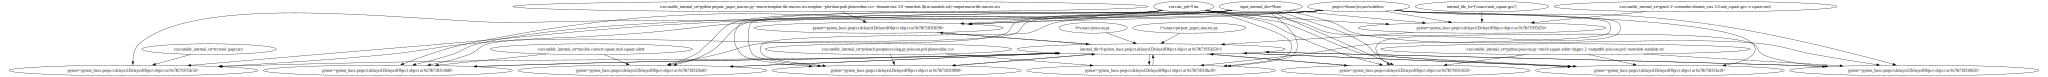

In [14]:
draw(node_dict=nodes_dict, edge_lst=edges_lst)